In [1]:
import importlib
import torch
import IPython.display
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn.utils import resample
import librosa
import librosa.display
import os
import scipy.signal
import re
import sys
import common_func as cmm
import threading
import time
import queue
import pyaudio
import sys
import random 
importlib.reload(cmm)

<module 'common_func' from 'c:\\Users\\ryuhe\\Documents\\python\\vae\\common_func.py'>

In [11]:
# avoiding'c'
target=['w', 'r', 't', 'y', 'p', 's', 'd', 'f', 'g', 'h', 'j','k', 'z', 'b', 'n', 'm']

target=['j', 's']
target=['k','s','t','n','h', 'm','y','r','w','g','z','j','d','b']
#read data from jvs
sr = 24000
frame_len=1024
read_data = []
read_label = []
no_label=[6,28,30,37,58,74,89]
count=0
for i in range(1,100):
  print(count)
  if i in no_label:
    continue
  tmp_data,tmp_label = cmm.read_jvs(i,sr,frame_len,target=target)

  read_data.append(tmp_data)
  read_label.append(tmp_label)
  count=count+1
  if count >= 100:
    break
read_data = np.concatenate(read_data)
read_label = np.concatenate(read_label)
print(read_data.shape)

0
1
2
3
4
5
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
26
27
27
28
29
30
31
32
33
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
82
83
84
85
86
87
88
89
90
91
(62510, 1024)


In [12]:

read_data = np.array(read_data,dtype="float64")
for i,l in enumerate(read_label):
  read_label[i] = target.index(l)%len(target)
  print(l)
read_label = np.array(read_label,dtype="int64")


j
n
y
y
y
y
n
n
r
d
w
w
w
r
r
s
s
r
m
m
s
r
m
m
s
m
m
m
n
h
r
y
y
m
j
n
r
h
w
w
w
r
r
r
n
n
y
r
r
m
r
r
w
r
r
n
m
n
m
w
w
n
m
r
r
r
r
b
h
r
z
z
w
w
s
n
w
w
w
m
n
d
d
n
r
n
s
s
r
z
w
w
r
r
n
w
w
w
w
w
z
m
n
r
n
m
m
g
m
n
s
b
s
s
r
m
z
y
m
w
w
r
y
y
r
y
r
m
r
b
r
j
s
b
s
s
b
r
m
m
j
r
r
s
m
r
m
n
d
n
t
h
r
g
n
w
w
r
z
j
m
m
m
m
n
b
r
m
m
r
y
b
b
m
n
s
m
r
r
z
m
r
s
r
w
w
r
g
g
m
n
r
r
m
s
n
m
w
r
n
m
r
r
s
r
z
r
r
w
w
w
w
b
m
m
g
n
g
w
w
j
n
r
r
r
r
r
r
h
r
w
m
g
n
s
n
b
r
y
n
m
r
w
w
w
w
w
n
h
h
w
w
w
m
m
n
r
y
r
r
r
w
b
w
w
n
r
r
r
j
r
r
r
h
g
y
y
r
r
j
s
s
m
s
r
r
m
r
g
r
r
r
b
r
y
r
s
r
m
r
w
n
r
r
r
b
s
g
y
y
m
y
s
r
j
y
j
y
w
w
r
g
h
n
y
y
y
r
b
b
z
r
r
y
r
m
m
m
r
r
r
y
m
m
r
n
j
y
s
m
m
n
m
m
n
m
s
n
n
r
h
m
r
b
r
r
w
d
m
r
r
y
y
y
r
b
d
r
z
r
w
w
w
r
s
n
n
y
r
w
w
r
r
t
n
r
r
m
b
r
y
y
n
r
r
n
n
m
m
w
w
r
d
r
m
m
m
g
g
m
r
r
r
m
y
y
y
g
y
h
s
m
g
n
r
w
r
w
b
n
r
r
d
r
r
y
y
j
b
r
r
r
n
n
z
y
n
s
w
w
w
b
m
s
s
n
n
s
h
r
r
n
j
y
y
y
y
j
j
h
g
r
n
s
w
y
n
r
y
y
r
z
w
r
n
n
n
r
r
j


In [13]:
# 各クラスの数をカウント
class_counts = np.bincount(read_label)
for cnt in class_counts:
  print(cnt)
# 最少のクラス数を取得
min_class_count = np.min(class_counts)

# 各クラスごとにサンプリング数を均等化
balanced_data = []
balanced_label = []

for class_label in np.unique(read_label):
    class_indices = np.where(read_label == class_label)[0]
    balanced_indices = resample(class_indices, n_samples=min_class_count, random_state=42)

    balanced_data.extend(read_data[balanced_indices])
    balanced_label.extend(read_label[balanced_indices])

balanced_data = np.array(balanced_data)
balanced_label = np.array(balanced_label)

print(balanced_label.shape)
print(read_label[0])
sample_num = 50000
if balanced_data.shape[0]>sample_num:
  random_index = random.sample(range(balanced_data.shape[0]),sample_num)
  random_index = np.array(random_index)
  balanced_data = balanced_data[random_index]
  balanced_label = balanced_label[random_index]

363
5343
143
15580
1581
8942
5329
7267
6565
2537
1542
2716
1965
2637
(2002,)
11


In [14]:
pitch_shifted_label = []
pitch_shifted_data = []
pitch_ran = np.arange(-3,3,1)

for n,audio in enumerate(balanced_data):
  for i in pitch_ran:
    audio=audio.astype(np.float32)
    shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=i,n_fft=64)  # ピッチを上げる
    pitch_shifted_data.append(shifted)
    pitch_shifted_label.append(balanced_label[n])

In [15]:
augmented_data = pitch_shifted_data
augmented_label = pitch_shifted_label

In [16]:
#input_dim = 80  # メルスペクトログラムの次元数

#n_fft = 800
#hop_length = 160



# augmented_dataの音声データを順番に再生
augmented_data = np.array(augmented_data)
augmented_label = np.array(augmented_label)
print(augmented_data.shape)
print(augmented_label.shape)
number = 0
print(augmented_label[number])
IPython.display.Audio(augmented_data[number], rate=sr)

(12012, 1024)
(12012,)
0


In [17]:
from torch.utils.data.dataset import random_split
# メルスペクトログラムの抽出
mel_data = []
input_dim = 64
n_fft = 64
hop_length = 8
n_mels = input_dim


print(augmented_data.shape)
for audio in augmented_data:
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,center=False)
    log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    #log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=2.0e-06)
    mel_data.append(log_mel_spec)
def normal(x):

  x_scaled = (x-x.min())/(x.max()-x.min())

  return x_scaled
np_meldata = np.array(mel_data)
print(np_meldata.shape)

(12012, 1024)
(12012, 64, 121)


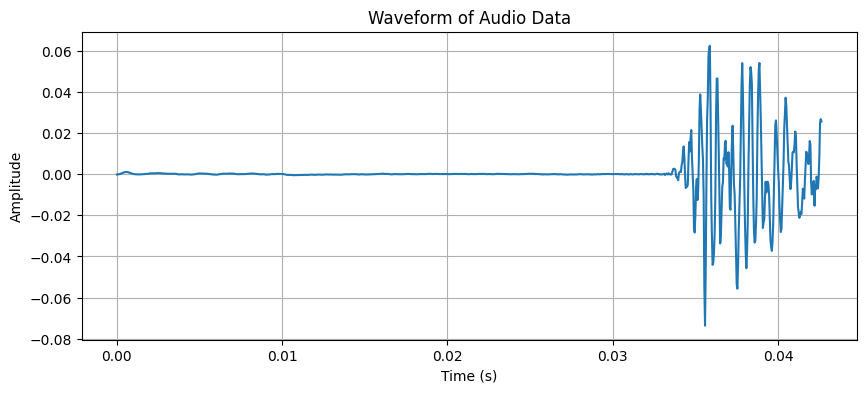

In [10]:
%matplotlib inline
# サンプリングレートとサンプル数を指定
sample_rate = sr  # サンプリングレート (Hz)
num_samples = frame_len  # サンプル数

# サンプルデータを生成（仮のデータとしてランダムな値を使用）
# ここで、実際の音声データを使用する場合は、適切な方法で読み込んでください。
audio_data = augmented_data[4]

# サンプル数を時間に変換
time = np.arange(0, num_samples) / sample_rate

# 波形グラフをプロット
plt.figure(figsize=(10, 4))
plt.plot(time, audio_data)
plt.title('Waveform of Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

12012
9609


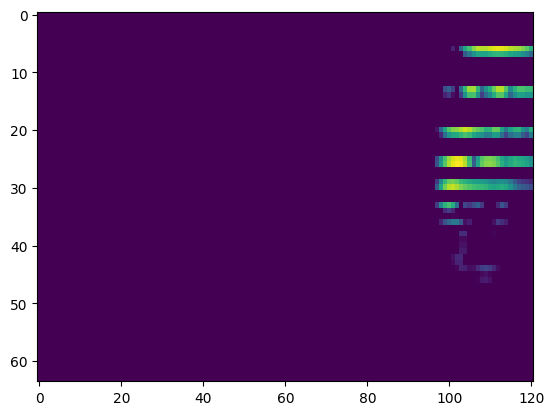

In [18]:

# 特徴量:メルスペクトログラム
x_size = np_meldata.shape[1]
y_size = np_meldata.shape[2]
fig, axs = plt.subplots(1,1)
axs.imshow(np_meldata[1],aspect="auto")
#標準化
dataset_mean=0
dataset_std=0

normaled_np_meldata = normal(np_meldata)
batch_size = 20


# データセット作成
normaled_np_meldata = normaled_np_meldata[:,np.newaxis,:,:]

X = torch.tensor(normaled_np_meldata,dtype=torch.float32)
Y = torch.tensor(augmented_label,dtype=torch.int64)
dataset = torch.utils.data.TensorDataset(X,Y)

train_size = int(0.8*len(dataset))
eval_size = len(dataset)-train_size
print(train_size+eval_size)
train_dataset,eval_dataset = torch.utils.data.random_split(dataset,[train_size,eval_size])
print(len(train_dataset))

dataloader_train =  torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=0
)
dataloader_valid =  torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=300,
    shuffle=True,
    num_workers=0
)


In [19]:
num_epochs = 20
device = torch.device("cuda")

EPOCH: 0 loss: 805317.4375
EPOCH: 1 loss: 583143.8125
EPOCH: 2 loss: 569333.0
EPOCH: 3 loss: 563416.5
EPOCH: 4 loss: 559834.8125
EPOCH: 5 loss: 556455.875
EPOCH: 6 loss: 552706.8125
EPOCH: 7 loss: 548961.8125
EPOCH: 8 loss: 546664.9375
EPOCH: 9 loss: 545054.1875
EPOCH: 10 loss: 543647.3125
EPOCH: 11 loss: 542699.625
EPOCH: 12 loss: 541659.5625
EPOCH: 13 loss: 540992.4375
EPOCH: 14 loss: 540233.0625
EPOCH: 15 loss: 539735.5625
EPOCH: 16 loss: 538937.9375
EPOCH: 17 loss: 538454.75
EPOCH: 18 loss: 538071.875
EPOCH: 19 loss: 537932.9375


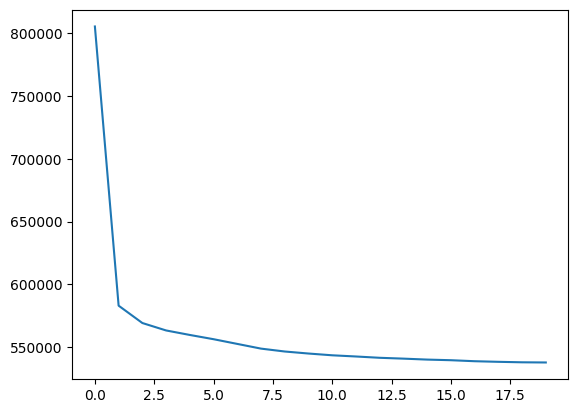

In [20]:

model = cmm.VAE(x_dim=x_size*y_size, z_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()


loss_list = []
for i in range(num_epochs):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      loss, z, y = model(x, device)
      model.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  loss_list.append(np.average(losses))
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

plt.plot(loss_list)

plt.show()


[10 11  7  9 12  9  1  4 11  2]


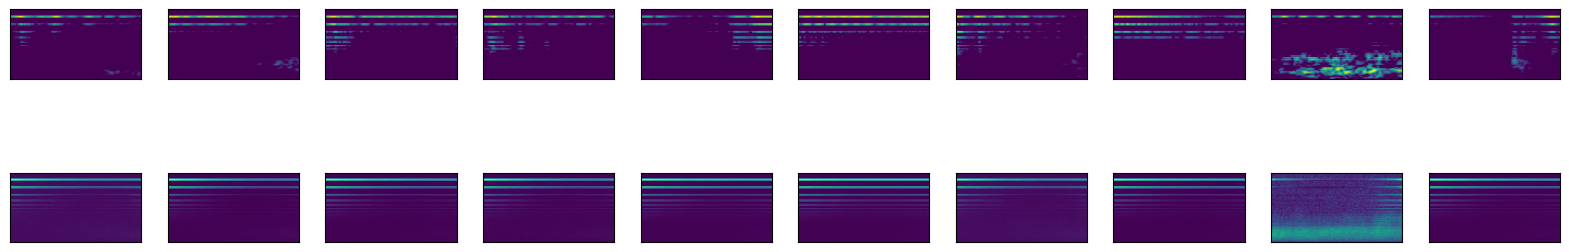

In [21]:
fig = plt.figure(figsize=(20, 6))

model.eval()
zs = []
for x, t in dataloader_valid:
    print(t.detach().numpy()[:10])
    for i, im in enumerate(x.view(-1, x_size, y_size).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im)

    x = x.to(device)
    tmp, z, y = model(x,device)
    zs.append(z)
    y = y.view(-1, x_size, y_size)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im)
    break

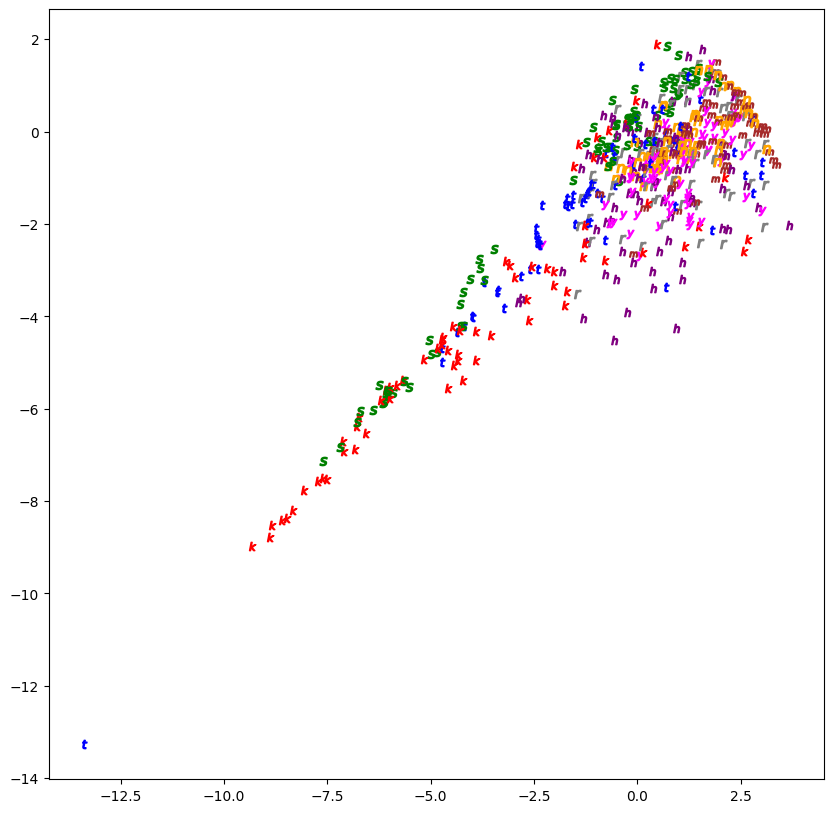

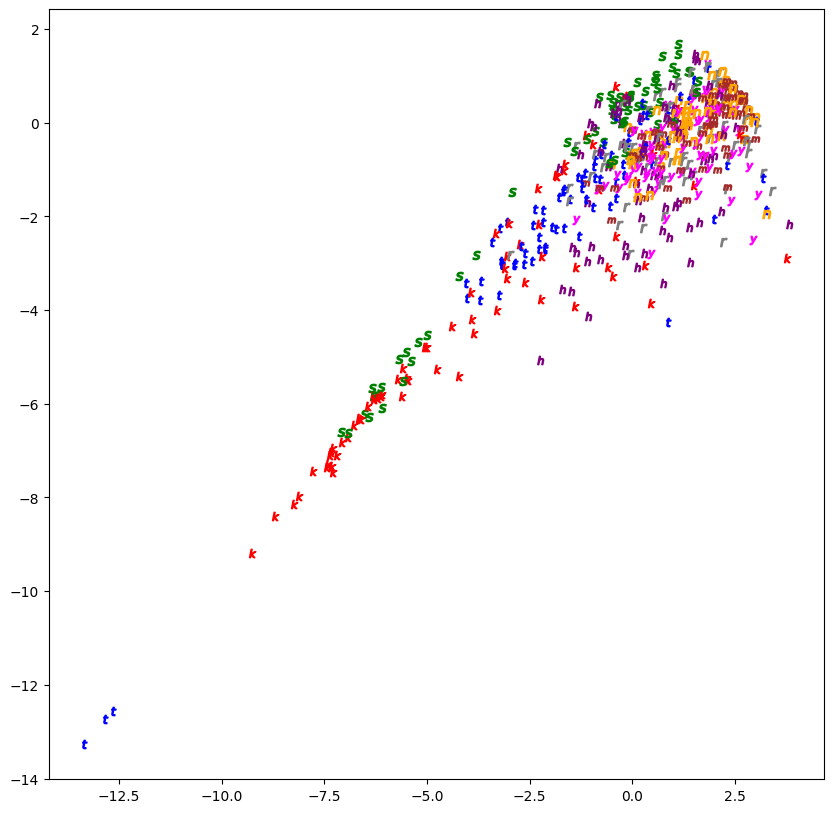

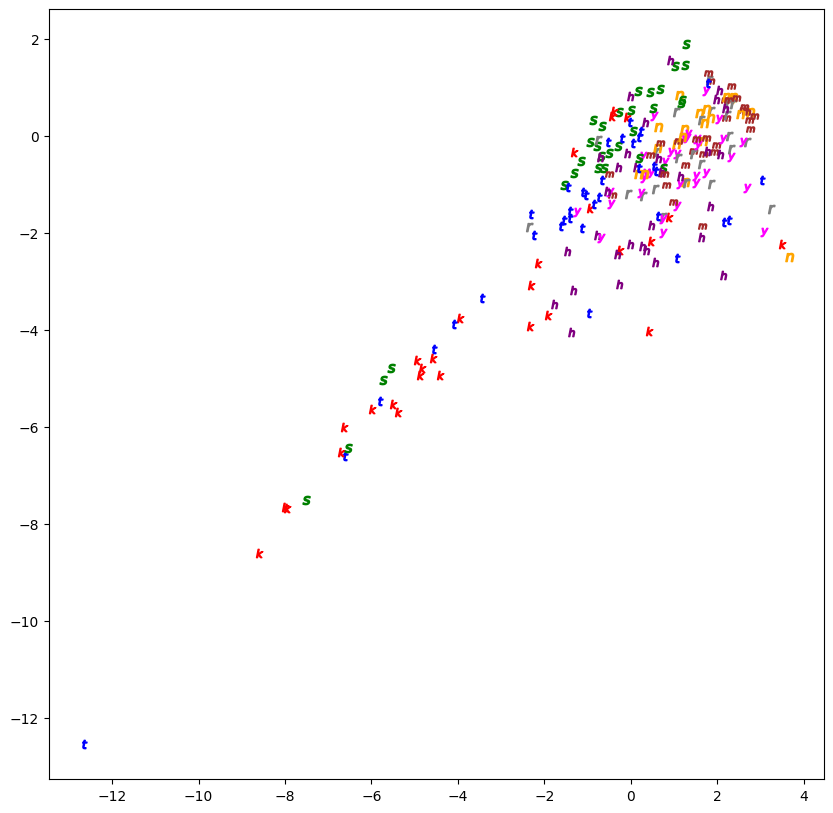

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [23]:
from sklearn.manifold import TSNE
from random import random


labeltoword = target
colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","olive","lime","skyblue","slategray","crimson","seagreen","aqua","indigo"]
target_phoneme = ["k","s","t","n","h","m","y","r"]
def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = zs
  for p, l in zip(points, labels):
    if target[l] in target_phoneme:
      plt.scatter(p[0], p[1], marker="${}$".format(labeltoword[l]), c=colors[l])
  plt.show()

model.eval()
zs = []

dataloader_valid =  torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=1000,
    shuffle=True,
    num_workers=0
)
data = []
label = []
cnt = 0
for x, t in dataloader_valid:
    if cnt>2:
      break
    x = x.to(device)
    t = t.to(device)

    # generate from x
    tmp, z, y = model(x,device)
    z = z.cpu()
    t = t.cpu()
    data.append(z.detach().numpy())
    label.append(t.detach().numpy())
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    cnt = cnt+1
data = np.array(data)
label = np.array(label)
print(data.shape)
print(label.shape)
for x, t in dataloader_train:

    x = x.to(device)
    t = t.to(device)
    # generate from x
    tmp, z, y = model(x,device)
    z = z.cpu()
    t = t.cpu()
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    break